# Mount Google Drive

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

# Import packages

In [2]:
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
#import datetime
import numpy as np
import tensorflow as tf
from scipy.stats import norm
import glob

from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import Dropout

#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_absolute_error
#from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels import regression

# Load data

In [3]:
# time: 2019-12-07 - 2020-12-07
# load DAX data - THIS WILL BE THE BENCHMARK
DAX=pd.read_csv('Data Sets/Portfolio Data/^GDAXi.csv', delimiter=',', usecols=[0, 5])
#DAX.info()#see if there are any missing values
DAX.head()
#we only need columns 1 and 6, i.e. Date and Adjusted Close

#save time for later use
time = DAX['Date']

In [4]:
# load data for each stock and combine to dataframe 
all_files = glob.glob(os.path.join('Data Sets/Portfolio Data/Stocks', "*.csv"))

df_from_each_file = (pd.read_csv(f, usecols=[5]) for f in all_files)
all_stocks   = pd.concat(df_from_each_file, ignore_index=True, axis=1)

#rename columns after stock ticker label
ticker_labels=['LIN', 'VOW3', 'MTX', 'BAS', 'FME', 'DBE', 'DAI', 'DHER', 'DTE', 'SAP', 'IFX', 'DB1', 'ADS', 'FRE', 'CON', 'MRK', 'ALV', 'RWE', 'BMW', 'MUV2', 'DWNI', 'BAYN', '1COV', 'HEN3', 'EQAN', 'VNA', 'DPW', 'BEI', 'HEI', 'SIE']

all_stocks.columns = ticker_labels
#all_stocks.info()#get some info

all_stocks.describe() #get some descriptive statistics
#we see that the shape is (252, 30) but the count is only 250, so two lines of values are missing
## fill this line by interpolation, this is a linear transformation!
all_stocks.interpolate(method='index', inplace=True, axis=0)
all_stocks.describe() #check


,LIN,VOW3,MTX,BAS,FME,DBE,DAI,DHER,DTE,SAP,...,DWNI,BAYN,1COV,HEN3,EQAN,VNA,DPW,BEI,HEI,SIE
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,189.005185,138.446970,175.880917,50.225629,69.359427,7.708302,39.966044,84.519405,13.848329,117.518925,...,39.327714,58.521125,35.896334,83.909542,9.503355,51.392088,32.154536,97.750796,50.882313,103.623111
std,19.190928,19.799615,49.893725,6.710776,5.243837,1.150638,8.548909,14.186688,1.239948,15.000184,...,4.016244,9.168157,6.424512,6.964385,0.681481,6.409833,6.152882,4.956462,8.189460,13.802367
min,137.208221,84.115631,103.651169,34.059311,54.174774,4.871000,20.560038,49.299999,9.887083,85.095543,...,27.610497,40.360001,22.177183,62.037773,7.540198,36.271557,17.689608,82.210518,28.293339,60.880001
25%,177.894401,128.141292,145.412498,46.911250,67.030962,6.943750,34.770190,70.534998,13.331863,104.123815,...,36.137267,50.501858,31.786692,80.002312,9.040696,45.985435,27.644617,94.250002,46.937499,98.522499
50%,189.439247,135.260254,156.724998,51.345000,70.817082,7.865500,40.660284,87.759998,14.147699,118.979095,...,39.800001,57.740000,35.452067,86.329998,9.611366,52.194161,31.722500,97.789997,52.190000,109.062687
75%,205.496212,149.865005,205.550003,54.870894,72.667400,8.431500,46.331397,96.985002,14.853750,132.424995,...,42.892500,66.721577,42.092500,89.039583,10.001250,57.370001,38.272500,101.412501,57.857025,112.960001
max,221.005188,178.957947,279.030914,61.330002,77.698875,10.204000,58.209999,114.800003,15.420000,142.259995,...,46.310001,74.811554,47.619999,93.339996,10.955239,62.220001,41.950001,106.907417,63.945572,120.099998


# Correlation between different stocks 

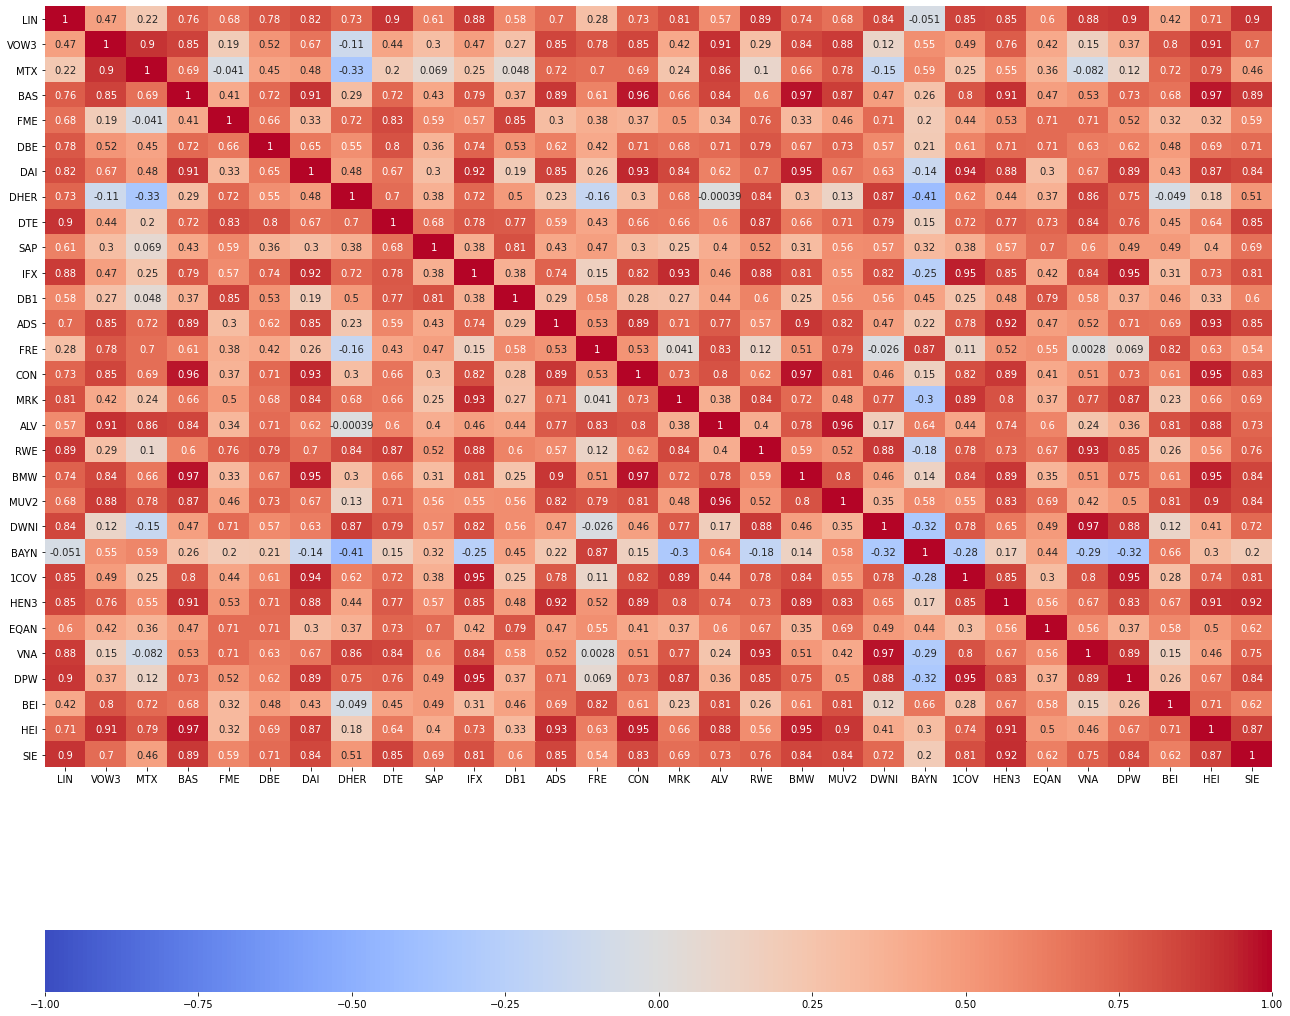

In [5]:
import seaborn as sb

#lets first use a linear correlation coefficient
fig = plt.figure(figsize=(22, 20))
sb.heatmap(all_stocks.corr(method='pearson'), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', cbar_kws= {'orientation': 'horizontal'})
plt.show()

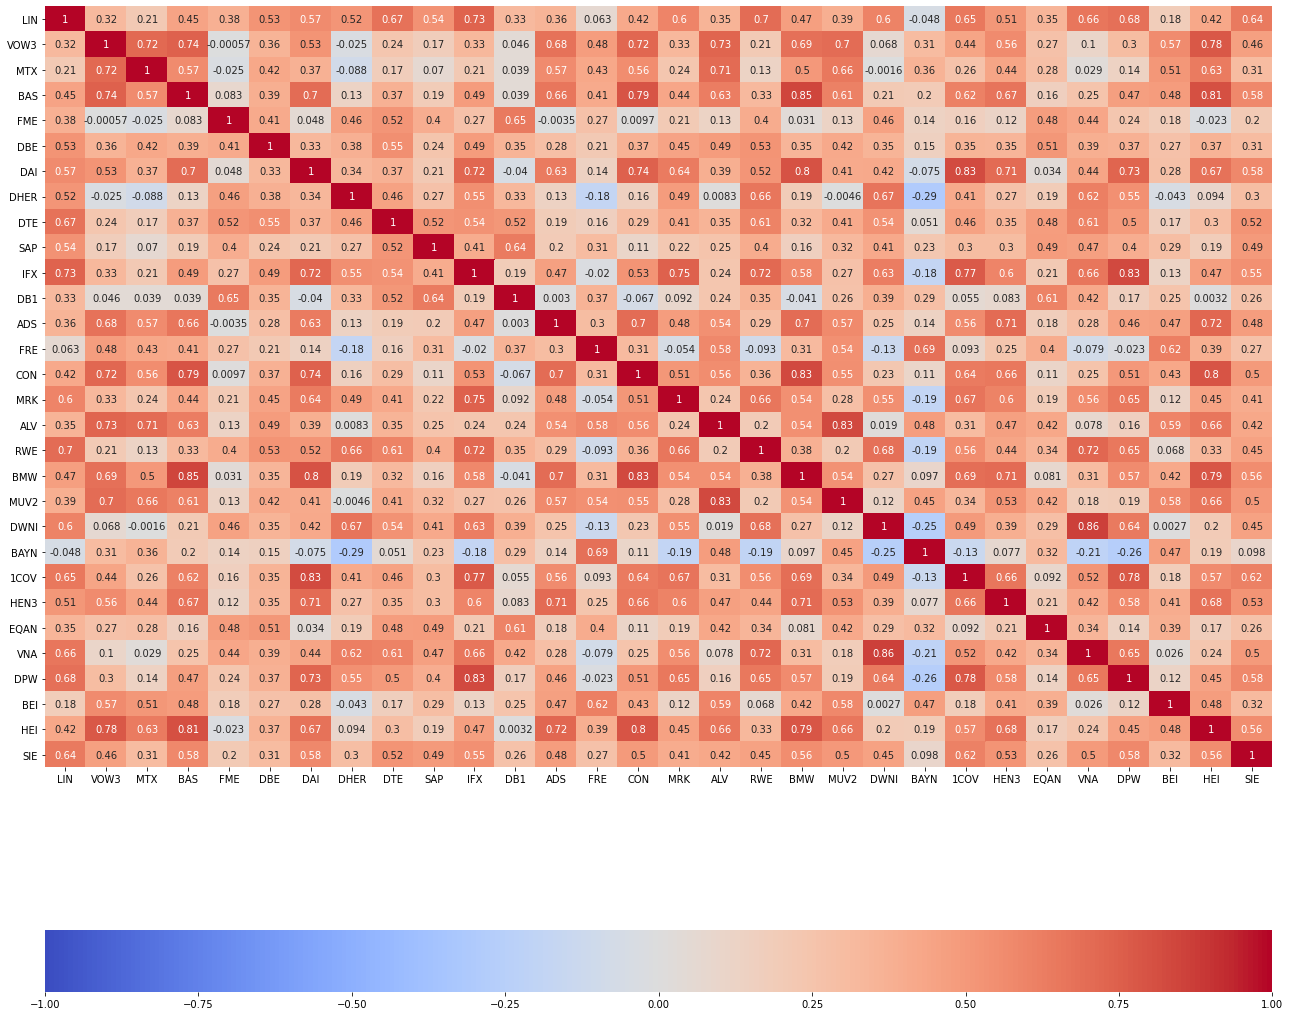

In [6]:
fig = plt.figure(figsize=(22, 20))
sb.heatmap(all_stocks.corr(method='kendall'), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', cbar_kws= {'orientation': 'horizontal'})
plt.show()


# Define functions for performance measuring

In [7]:
def calc_returns(data):
    return np.diff(np.log(data), axis=0)

#using the CAPM we can find alpha and beta for a portfolio by estimating the parameters of a simple OLS regression
def simple_OLS(y, x):
    x = sm.add_constant(x) #include an intercept (which is turned off by default)
    OLS = regression.linear_model.OLS(y, x).fit()
    intercept = OLS.params[0] # this will be alpha
    beta = OLS.params[1] # beta
    return intercept, beta

def B_summary(benchmark):
    exp_bench_returns = np.mean(benchmark, axis=0) * 252 #(30x1)vector
    covs = np.cov(benchmark, rowvar=False) * 252 # (30x30) variance-covariance matrix

    B_exp_returns = np.sum(exp_bench_returns * weights) #output is scalar
    B_volatility = np.sqrt(covs) #scalar
    B_sharpe_ratio = B_exp_returns / B_volatility
    B_returns_ot = benchmark
    B_sharpe_ratio_ot = B_returns_ot / B_volatility
    
    return np.asarray([B_exp_returns, B_volatility, B_sharpe_ratio, B_returns_ot, B_sharpe_ratio_ot])


#define a function which returns cumulative values for a given portfolio
##here we can pass the function a matrix of returns and a vector of weights

def P_summary(stocks, weights, benchmark):
    weights = weights #(30x1)vector
    exp_stock_returns = np.mean(stocks, axis=0) * 252 #(30x1)vector
    covs = np.cov(stocks, rowvar=False) * 252 # (30x30) variance-covariance matrix
    
    P_exp_returns = np.sum(exp_stock_returns * weights) #output is scalar
    P_volatility = np.sqrt(np.dot(np.transpose(weights), np.dot(covs, weights))) #scalar

    #we want to track these metrics over time, i.e. output is (252x1)vector
    P_returns_ot = np.dot(stocks, np.transpose(weights)) #(251x1)vector
    P_sharpe_ratio_ot = P_returns_ot / P_volatility #(251x1)vector
    
    P_sharpe_ratio = P_exp_returns / P_volatility
    P_alpha = simple_OLS(P_returns_ot, benchmark)[0]
    P_beta = simple_OLS(P_returns_ot, benchmark)[1]
                            
    return np.asarray([P_exp_returns, P_volatility, P_sharpe_ratio, P_alpha, P_beta, P_returns_ot, P_sharpe_ratio_ot])


# Compute returns for benchmark and stocks

In [8]:
benchmark = calc_returns(DAX['Adj Close'])
stock_returns = calc_returns(all_stocks)

<Figure size 432x288 with 0 Axes>

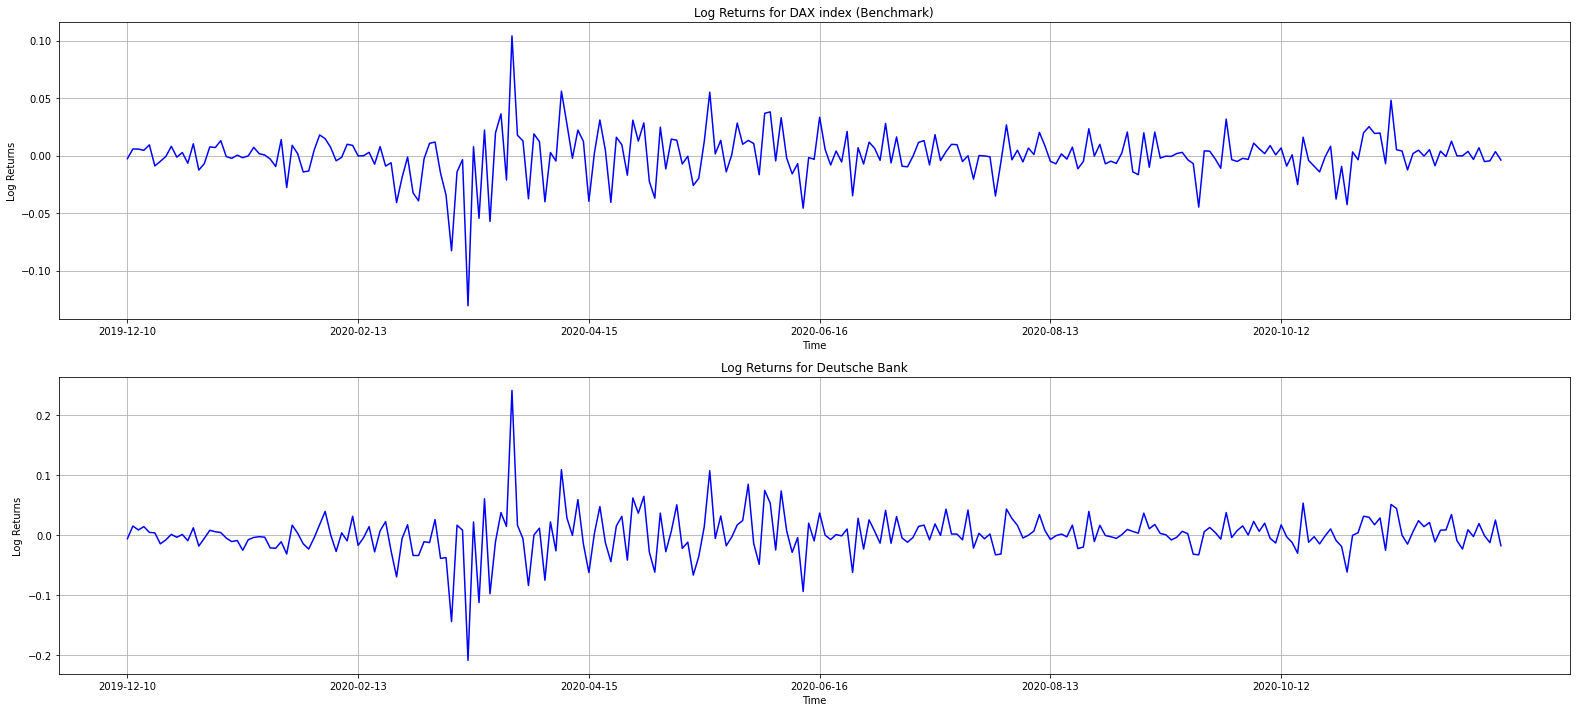

In [9]:

plt.clf()
fig = plt.figure(figsize=(22, 10))
plt.subplot(211)
plt.plot(time[1:], benchmark, color='b')
plt.xticks(np.arange(0,len(time),len(time)/6))
plt.ylabel('Log Returns')
plt.xlabel('Time')
plt.title('Log Returns for DAX index (Benchmark)')
plt.grid()

plt.subplot(212)
plt.plot(time[1:], stock_returns[:, 6], color='b')
plt.xticks(np.arange(0,len(time),len(time)/6))
plt.ylabel('Log Returns')
plt.xlabel('Time')
plt.title('Log Returns for Deutsche Bank')
plt.grid()

plt.tight_layout()
plt.show()

# Compare distributions of DAX index and e.g. Deutsche Bank stock

<Figure size 432x288 with 0 Axes>

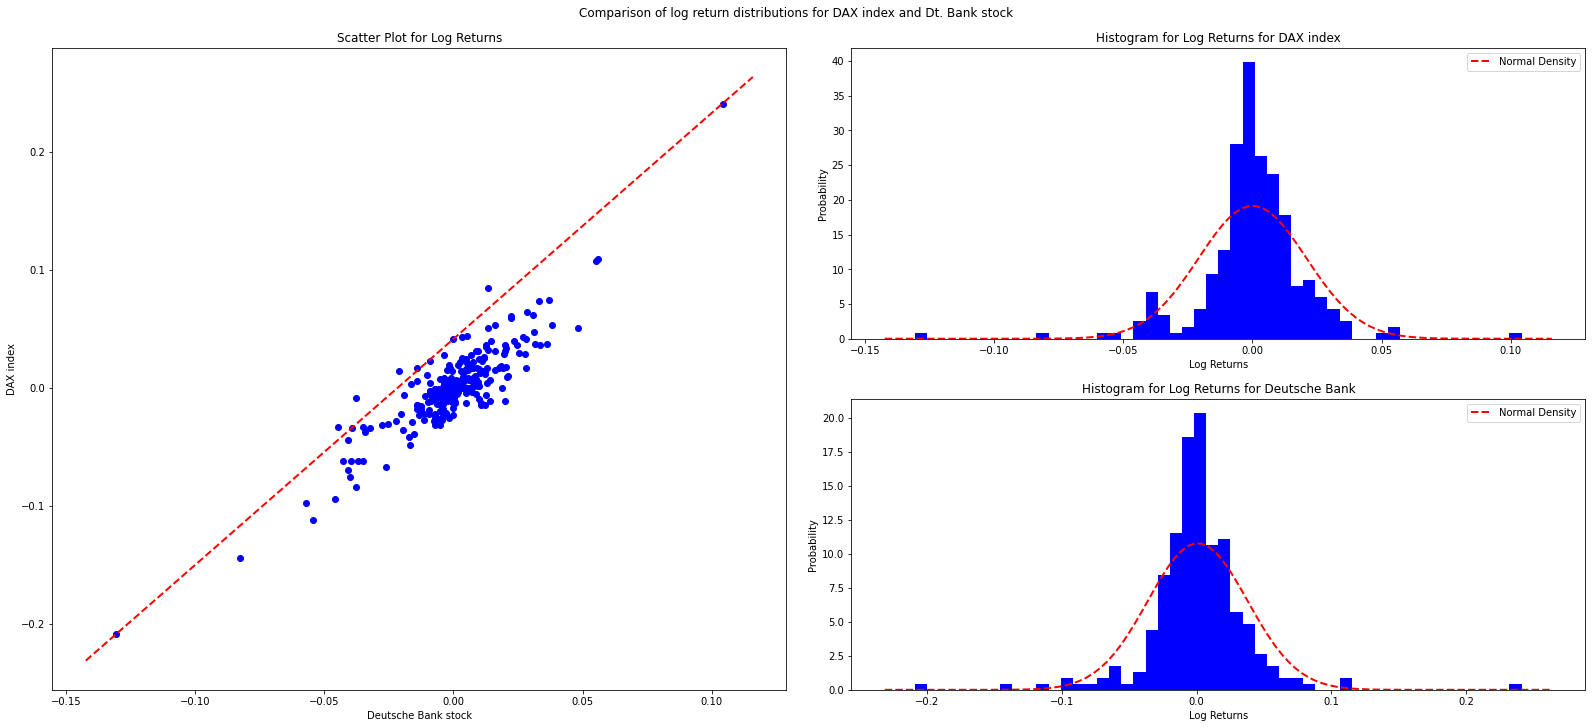

In [10]:
#fit normal distribution
mu_bench, sigma_bench = norm.fit(benchmark)
mu_asset, sigma_asset = norm.fit(stock_returns[:, 6])

plt.clf()
fig = plt.figure(figsize=(22, 10), constrained_layout=True)

gs = GridSpec(2, 2, figure=fig)
plt.subplot(gs[0:2, :-1])
plt.scatter(benchmark, stock_returns[:, 6], color='b')
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot(xlim, ylim, 'r--', linewidth=2)
plt.ylabel('DAX index')
plt.xlabel('Deutsche Bank stock')
plt.title('Scatter Plot for Log Returns')

plt.subplot(gs[0, -1])
plt.hist(benchmark, bins=50, color='b', density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
f_x_bench = norm.pdf(x, mu_bench, sigma_bench)
plt.plot(x, f_x_bench, 'r--', linewidth=2, label='Normal Density')
plt.xlabel('Log Returns')
plt.ylabel('Probability')
plt.title('Histogram for Log Returns for DAX index')
plt.legend()

plt.subplot(gs[1, -1])
plt.hist(stock_returns[:, 6], bins=50, color='b', density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
f_x_asset = norm.pdf(x, mu_asset, sigma_asset)
plt.plot(x, f_x_asset, 'r--', linewidth=2, label='Normal Density')
plt.xlabel('Log Returns')
plt.ylabel('Probability')
plt.title('Histogram for Log Returns for Deutsche Bank')
plt.legend()

fig.suptitle("Comparison of log return distributions for DAX index and Dt. Bank stock")
plt.show()

# Print performance statistics

In [11]:
#define some example weights, e.g. equal weights
n = len(ticker_labels)
weights = np.full((n), 1/n)#these weights stay fixed over 251 days


In [12]:
benchmark_summary = B_summary(benchmark)
print(benchmark_summary[0:3])
#B_exp_returns, B_volatility, B_sharpe_ratio, B_returns_ot, B_sharpe_ratio_ot

[0.010831774540975404 0.3316056488077372 0.03266462613022493]


In [13]:
portfolio_summary = P_summary(stock_returns, weights, benchmark)
print(portfolio_summary[0:5])
#P_exp_returns, P_volatility, P_sharpe_ratio, P_alpha, P_beta, P_returns_ot, P_sharpe_ratio_ot

[0.08155736205758747 0.31940002983704197 0.2553455054440604
 0.00028266175222266753 0.9533618391345674]


<Figure size 432x288 with 0 Axes>

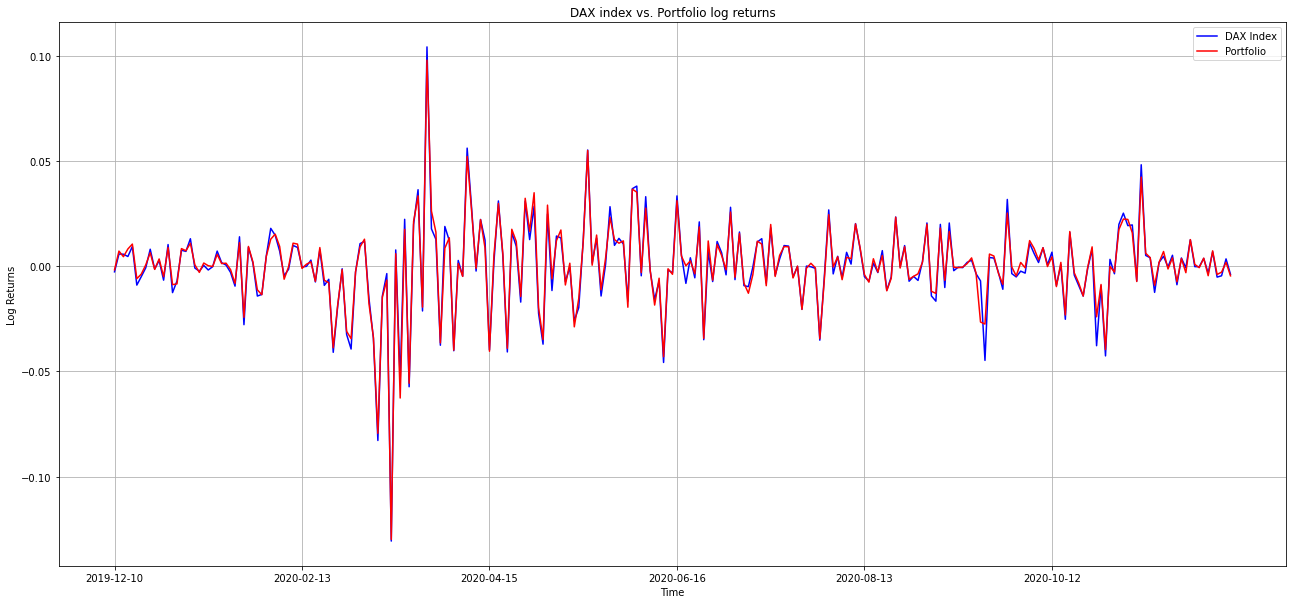

In [14]:
#compare portfolio returns to benchmark returns

plt.clf()
fig = plt.figure(figsize=(22, 10))
plt.plot(time[1:], benchmark, color='b', label='DAX Index')
plt.plot(time[1:], portfolio_summary[5], color='r', label='Portfolio')
plt.xticks(np.arange(0,len(time),len(time)/6))
plt.ylabel('Log Returns')
plt.xlabel('Time')
plt.title('DAX index vs. Portfolio log returns')
plt.grid()
plt.legend()
plt.show()

#so with equal weights we obtain practically the same returns, which can also
#be inferred from alpha=0.00028 and beta=0.95336
#we also see that by holding all individual stocks equally we obtain a higher sharpe ratio and lower volatility, but at the same time the expected return is about 2% higher for trading the DAX index

# Optimization part

In [15]:

import scipy.optimize as sco


def min_func_sharpe(weights):
    return -P_summary(stock_returns, weights, benchmark)[2]

cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bnds = tuple((0, 1) for x in range(n))

weights = np.full((n), 1/n)

In [16]:

opt_sharpe = sco.minimize(min_func_sharpe, weights,
                    method='SLSQP', bounds=bnds, constraints=cons)
                    #SLSQP= sequential least squares programming
opt_sharpe

     fun: -1.5352998408001302
     jac: array([ 4.83832702e-01,  1.56093121e+00,  1.47517663e+00,  6.47327155e-01,
        3.50606009e-01,  2.09331512e-04,  6.06899694e-01, -7.90059566e-05,
        3.79566148e-01,  1.24990019e+00,  1.37150049e-01,  7.54548669e-01,
        7.76192531e-01,  1.43521854e+00,  5.76300278e-01,  2.08020210e-05,
        9.50410008e-01,  6.29574060e-05,  7.14802101e-01,  8.62955958e-01,
        5.40877432e-02,  1.66831768e+00,  1.91768661e-01,  5.03038749e-01,
        4.81144741e-01,  1.63018703e-04,  2.46670455e-01,  8.01806509e-01,
        9.21414405e-01,  8.69601741e-01])
 message: 'Optimization terminated successfully'
    nfev: 279
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([5.24003767e-17, 0.00000000e+00, 1.13619986e-15, 0.00000000e+00,
       0.00000000e+00, 1.13842331e-01, 0.00000000e+00, 5.97258249e-01,
       0.00000000e+00, 2.12761935e-16, 0.00000000e+00, 0.00000000e+00,
       1.62868618e-16, 5.66653460e-16, 2.08032839e-16, 8

In [17]:

min_sharpe_opt_weights = opt_sharpe['x'].round(5)

portfolio_summary = P_summary(stock_returns, min_sharpe_opt_weights, benchmark)
print(portfolio_summary[0:5])
#P_exp_returns, P_volatility, P_sharpe_ratio, P_alpha, P_beta, P_returns_ot, P_sharpe_ratio_ot


#[0.08155736205758747 0.31940002983704197 0.2553455054440604 0.00028266175222266753 0.9533618391345674]


[0.5588847673282479 0.36402320417638817 1.535299840549283
 0.0021895612013285446 0.6568955591291652]


In [18]:

def min_func_volatility(weights): 
    return P_summary(stock_returns, weights, benchmark)[1]

opt_vola = sco.minimize(min_func_volatility, weights,
                        method='SLSQP', bounds=bnds, constraints=cons)
                        
opt_vola

min_vola_opt_weights = opt_vola['x'].round(5)

portfolio_summary = P_summary(stock_returns, min_vola_opt_weights, benchmark)
print(portfolio_summary[0:5])
#P_exp_returns, P_volatility, P_sharpe_ratio, P_alpha, P_beta, P_returns_ot, P_sharpe_ratio_ot

#reduced the expected return by 2% but reduced the volatility by 22%

[0.05902151428687198 0.20499983645858327 0.2879100554736114
 0.00021338246032384843 0.4846052016135682]


In [19]:

def max_func_exp_ret(weights): 
    return -P_summary(stock_returns, weights, benchmark)[0]

opt_exp_ret= sco.minimize(max_func_exp_ret, weights,
                        method='SLSQP', bounds=bnds, constraints=cons)
                        
#get results
opt_exp_ret

#get the weights vector
max_exp_ret_opt_weights = opt_exp_ret['x'].round(5)

#apply to portfolio function
portfolio_summary = P_summary(stock_returns, max_exp_ret_opt_weights, benchmark)
print(portfolio_summary[0:5])
#P_exp_returns, P_volatility, P_sharpe_ratio, P_alpha, P_beta, P_returns_ot, P_sharpe_ratio_ot

#so now we get an expected return of 71%, instead of 8% for the initial portfolio and 10% for the benchmark
#note that more return comes at a price of increased risk, here we are faced with 18% more volatility

[0.7149216642390323 0.4961617811156611 1.4409043409822322
 0.0028154821517184115 0.5003946477549465]


# PCA
Principal component analysis (PCA) is a statistical procedure that uses orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to (i.e., uncorrelated with) the preceding components.

Think of these components as linear combinations (i.e. portfolios) of selected stocks from the DAX index. Instead of working with 30 correlated index constituents, one can then work with maybe 5, 3, or even only 1 principal component.

PCA is identifying that linear combination of security weights (i.e. an eigenvector) that has the highest variance which we call the market factor because the weights are generally the same sign. A portfolio constructed using these weights - an eigenportfolio - certainly would have high variance -- in fact it's the set of portfolio weights that produces the most volatility vs. any other set of portfolio weights since it loaded on the primary source of systematic risk. (As a side note, you could form a eigenportfolio that has minimum variance by identifying a principal component with a low eigenvalue.)

In [20]:
from sklearn.decomposition import KernelPCA

#normalize for PCA
scale_function = lambda x: (x - x.mean()) / x.std()

pca = KernelPCA().fit(scale_function(stock_returns))

len(pca.lambdas_)#number of eigenvalues

30

In [21]:
pca.lambdas_[:10].round()

array([4664.,  495.,  319.,  241.,  189.,  179.,  139.,  136.,  118.,
        105.])

In [22]:
get_we = lambda x: x / x.sum() #get relative importance of the components

get_we(pca.lambdas_)[:10]

array([0.6199912 , 0.06586174, 0.04246789, 0.03202421, 0.02509758,
       0.02375523, 0.01849502, 0.01812746, 0.01572956, 0.0139804 ])

In [23]:
get_we(pca.lambdas_)[:5].sum()
#first 5 components account for 79% of the variability

0.7854426193284046

<Figure size 432x288 with 0 Axes>

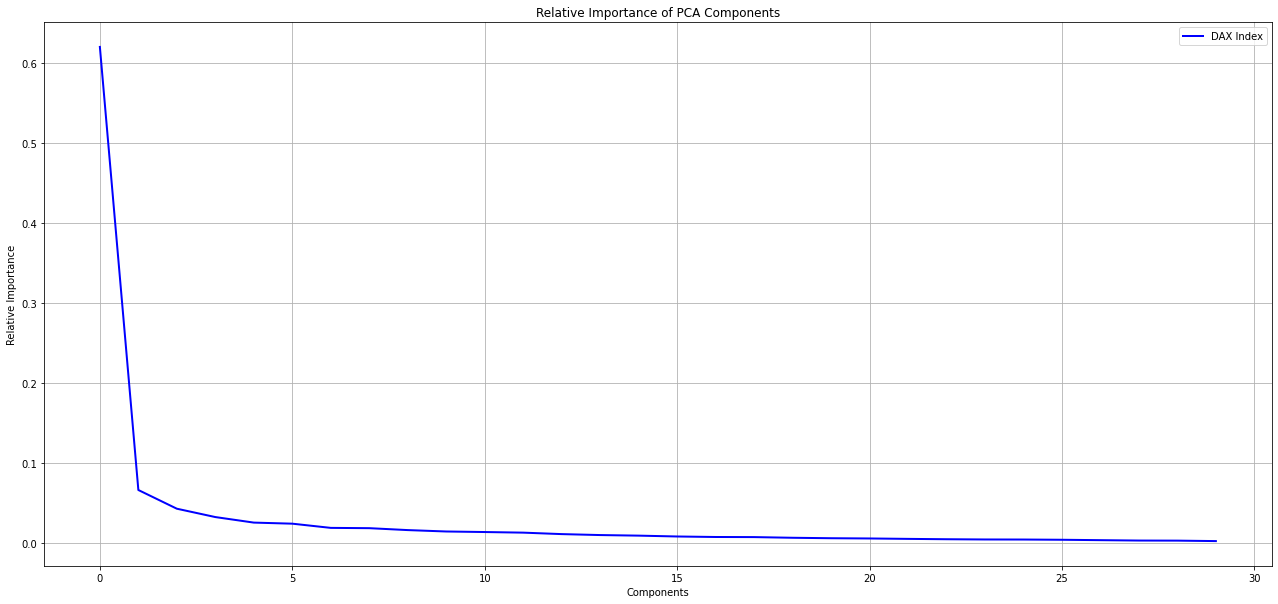

In [24]:

plt.clf()
fig = plt.figure(figsize=(22, 10))
plt.plot(get_we(pca.lambdas_), color='b', label='DAX Index', linewidth=2)
plt.ylabel('Relative Importance')
plt.xlabel('Components')
plt.title('Relative Importance of PCA Components')
plt.grid()
plt.legend()
plt.show()

Next:

We create a function to compute PCA with a volatility explained treshold of 95%. This function computes an inversed elbow chart that shows the amount of principle components and how many of them explain the volatility treshold.

Eigen Portfolios
- We compute several functions to determine the weights of each principle component. We then visualize a scatterplot that visualizes an organized descending plot with the respective weight of every company at the current chosen principle component.

We compute an iterable loop to compute the principle component's weights for each Eigen Portfolio, which then uses the sharpe ratio function to look for the portfolio with the highest sharpe ratio. Once we know which portfolio has the highest sharpe ratio, we can visualize its performance against the DAX index to understand how it outperforms it.

In [25]:
from sklearn.decomposition import PCA

stock_returns_df = pd.DataFrame(stock_returns, columns=ticker_labels)
covs = np.cov(stock_returns, rowvar=False) * 252 # (30x30) variance-covariance matrix
pca = PCA()
pca.fit(covs)
projected = pca.fit_transform(covs)
pcs = pca.components_

def sharpe_ratio(eigen_port_single):
    n_years = eigen_port_single.shape[0] / 252
    annualized_return = np.power(np.prod(1 + eigen_port_single), (1 / n_years))-1
    annualized_vol = eigen_port_single.std() * np.sqrt(252)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

n = len(pcs)
#allocate memory
annualized_ret = np.zeros((n))
sharpe_metric = np.zeros((n))
annualized_vol = np.zeros((n))

highest_sharpe = 0 

for i in range(0, n):
    pc_w = pcs[:, i] / sum(pcs[:, i])
    eigen_porti = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = ticker_labels)
    eigen_porti.sort_values(by=['weights'], ascending=False, inplace=True)
    
    eigen_porti_returns = np.dot(stock_returns_df.loc[:, eigen_porti.index], eigen_porti / n)
    eigen_porti_returns = pd.Series(eigen_porti_returns.squeeze(), index=stock_returns_df.index)
    er, vol, sharpe = sharpe_ratio(eigen_porti_returns)
    annualized_ret[i] = er
    annualized_vol[i] = vol
    sharpe_metric[i] = sharpe

# find portfolio with the highest Sharpe ratio
highest_sharpe = np.argmax(sharpe_metric)

results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results.dropna(inplace=True)
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)

print(results.head(3)) #index shows portfolio

      Return       Vol    Sharpe
23  1.070187  1.030790  1.038220
10  0.821677  1.389688  0.591268
11  0.550353  1.738839  0.316506


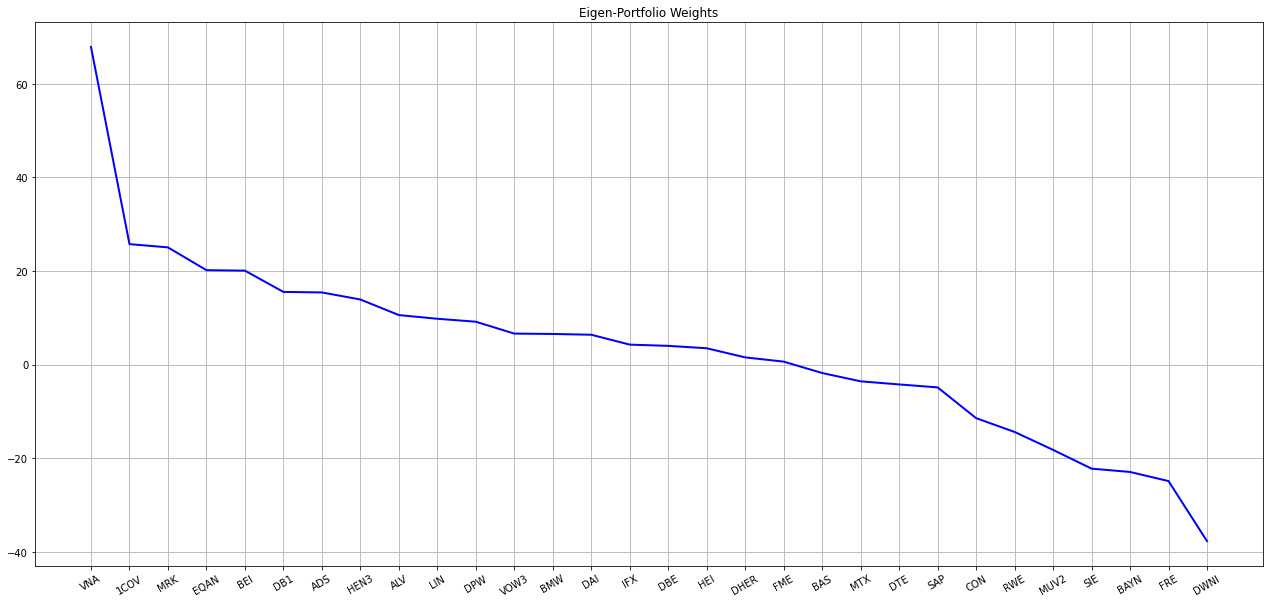

,weights
VNA,67.898505
1COV,25.739269
MRK,25.043193
EQAN,20.169717
BEI,20.068945
DB1,15.520423
ADS,15.412275
HEN3,13.898628
ALV,10.567882
LIN,9.781887


In [26]:
def PCWeights():
    weights = pd.DataFrame()

    for i in range(len(pcs)):
        weights["weights_{}".format(i)] = pcs[:, i] / sum(pcs[:, i])

    weights = weights.values.T
    return weights

weights_PCA = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = ticker_labels) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        fig = plt.figure(figsize=(22, 10))
        plt.plot(portfolio, color='b', linewidth=2)
        plt.xticks(range(0, len(ticker_labels), 1), rotation=30)
        plt.title('Eigen-Portfolio Weights')
        plt.grid()
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights_PCA[23], plot=True)

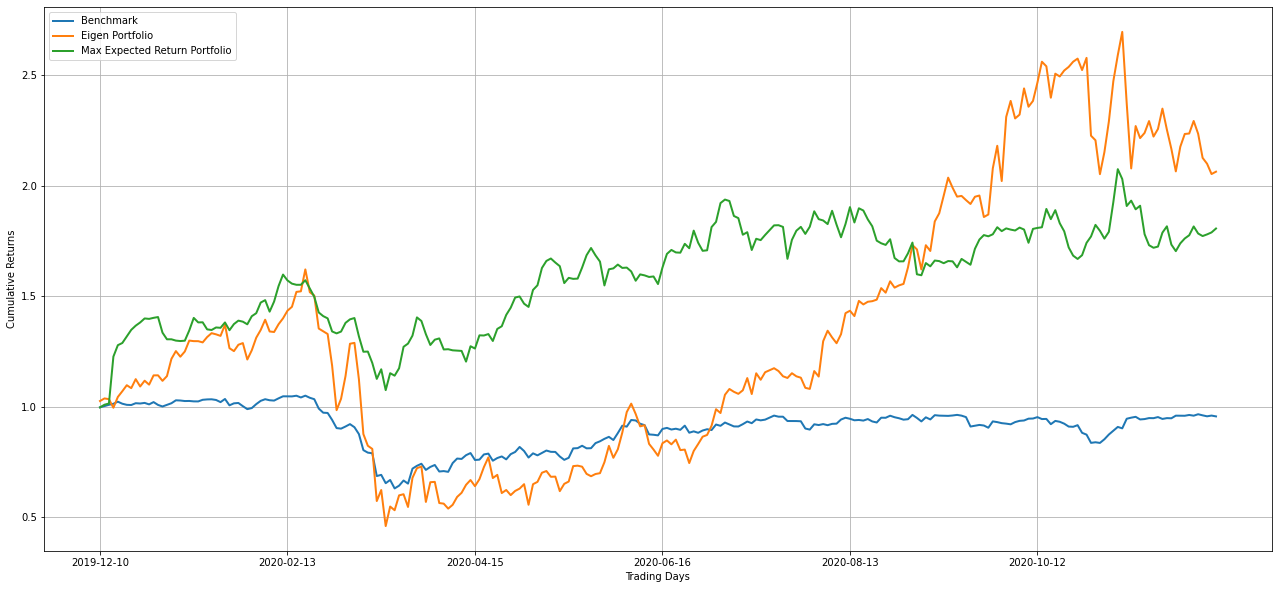

In [27]:
max_exp_port = P_summary(stock_returns, max_exp_ret_opt_weights, benchmark)

def plotSharpe(eigen, benchmark, plotting, return_returns):
    eigen_portfolio_returns = np.dot(stock_returns_df.loc[:, eigen.index], eigen / len(pcs))
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=stock_returns_df.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)

    if plotting:
        fig = plt.figure(figsize=(22, 10))
        plt.plot(time[1:], np.cumprod(benchmark[3]+1), label='Benchmark', linewidth=2)
        plt.plot(np.cumprod(eigen_portfolio_returns+1), label='Eigen Portfolio', linewidth=2)
        plt.plot(np.cumprod(max_exp_port[5]+1), label='Max Expected Return Portfolio', linewidth=2)
        plt.xticks(np.arange(0,len(time),len(time)/6))
        plt.ylabel('Cumulative Returns')
        plt.xlabel('Trading Days')
        plt.legend()
        plt.grid()
        plt.show()
    
    if return_returns:
        return eigen_portfolio_returns

plotSharpe(eigen=plotEigen(weights=weights_PCA[23]), benchmark=benchmark_summary, plotting=True, return_returns=False)

We see that the expected return-maximized portfolio from the beginning achieves very high returns while being much less volatile than the PCA optimized portfolio, outperforming the benchmark as well.

# Kelly's Criterion


In [28]:
#need package to solve convex optimization problem
import cvxopt as opt
from cvxopt import blas, solvers
import cvxpy as cp
import pyfolio as pf

#portfolio weights optimized by kelly criterion

#number of stocks
no_stocks = len(ticker_labels)
#define weights
weights_kelly = cp.Variable(no_stocks)
weights_kelly

Variable((30,))

In [29]:
#the portfolio returns are based on the daily return multiplied by the weight for each asset
port_ret_kelly = np.array(stock_returns*weights_kelly)
port_ret_kelly

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cvxpy/expressions/expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


array(Expression(AFFINE, UNKNOWN, (251,)), dtype=object)

In [30]:
#the final portfolio value/utility can be computed using the logarithmic summation of the daily portfolio returns

port_final_kelly = cp.sum(cp.log(1+port_ret_kelly))
port_final_kelly
#the output tells us that the final portfolio value is an expression and is concave in nature and its value is unknown

/Users/lucaestivariz/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Expression(CONCAVE, UNKNOWN, ())

In [31]:
#the objective is to maximize the kelly criterion
#to do this, crate a parameter called 'objective' and assign it the maximization condition 
#then the maximization function of the cvxpy library takes on the rest
objective = cp.Maximize(port_final_kelly)
objective
#the output tells us that the objective is a maximization function over the expression, where the expression is concave in nature and its value is unknown

Maximize(Expression(CONCAVE, UNKNOWN, ()))

In [32]:
#before solving we need to note some restrictions:
##weights should be positive
##sum of weights should be lass than or equal to 1, as we are not considering any leveraging here
constraints = [0.0<=weights_kelly, cp.sum(weights_kelly)==1]
constraints
#Here the constraints specify that the first one is an inequality constraint and its value is a constant zero. While the second is an equality constraint between an affine expression whose value is equal to a constant non-negative value

[Inequality(Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))]

In [33]:
#now we combine the objective and the constraints to create a problem statement
#for this we can use the problem class of the cvxpy library
problem = cp.Problem(objective, constraints)
problem
#output describes the entire problem including all the previously defined expressions

Problem(Maximize(Expression(CONCAVE, UNKNOWN, ())), [Inequality(Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, NONNEGATIVE, ()))])

In [34]:
#to solve this problem we can use the solve method of the problem class
problem.solve()
#the optimal value for w is stored in w.value
print(weights_kelly.value)

[2.17023563e-11 7.06198149e-12 6.62870263e-12 1.62230861e-11
 1.88014564e-11 8.84356429e-11 2.93163819e-11 9.99999999e-01
 2.05958377e-11 7.66717751e-12 7.26900040e-11 1.44189274e-11
 1.46769813e-11 5.61161547e-12 1.95121635e-11 4.47413496e-11
 1.24249863e-11 5.93785336e-11 1.72072584e-11 1.28512444e-11
 2.84346806e-11 3.96114240e-12 3.28450839e-11 1.47103152e-11
 1.63690078e-11 3.61884212e-11 3.14902153e-11 9.62743101e-12
 1.22315539e-11 1.38932750e-11]


In [35]:
#now we check out the resulting performance 
port_kelly_summary = P_summary(stock_returns, weights_kelly.value, benchmark)
print(port_kelly_summary[0:4])

[0.7149216638722248 0.49616178084567497 1.4409043410270095
 0.002815482150248407]


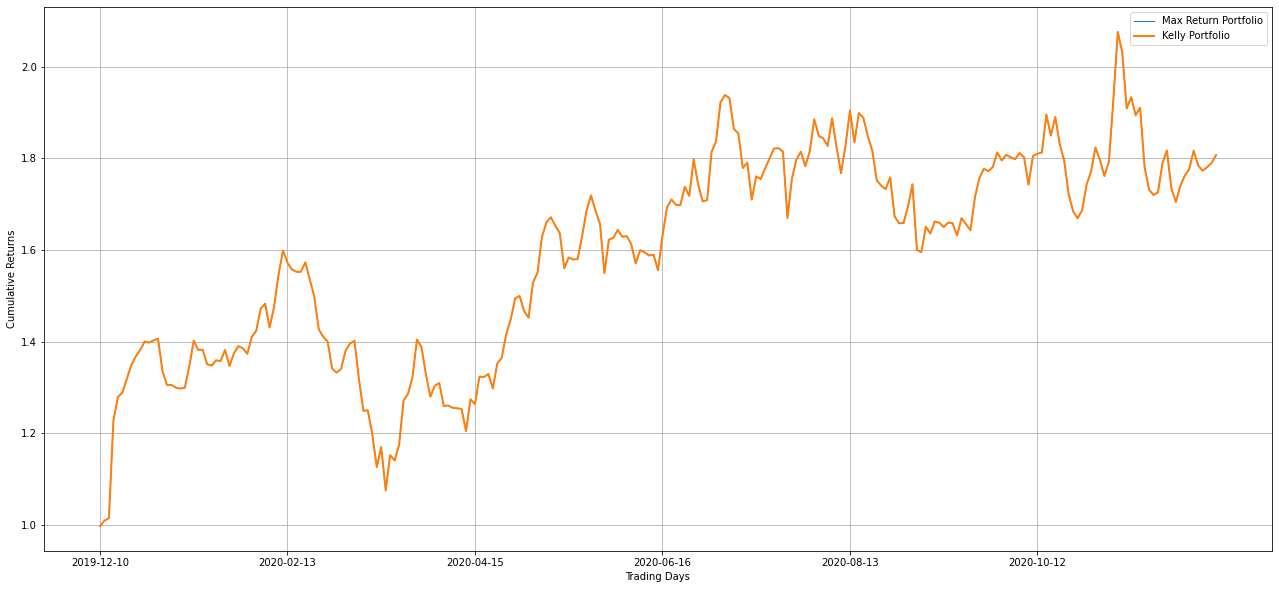

In [36]:
fig = plt.figure(figsize=(22, 10))
plt.plot(time[1:], np.cumprod(max_exp_port[5]+1), label='Max Return Portfolio', linewidth=1)
plt.plot(np.cumprod(port_kelly_summary[5]+1), label='Kelly Portfolio', linewidth=2)
plt.xticks(np.arange(0,len(time),len(time)/6))
plt.ylabel('Cumulative Returns')
plt.xlabel('Trading Days')
plt.legend()
plt.grid()
plt.show()

As we can see we obtain the exact same results as for the expected return-maximized portfolio from the beginning, which is in line with the theory, for instance see the following paper: 
https://arxiv.org/abs/1710.00431

In [37]:
print(port_kelly_summary[0:4])
print(max_exp_port[0:4])

[0.7149216638722248 0.49616178084567497 1.4409043410270095
 0.002815482150248407]
[0.7149216642390323 0.4961617811156611 1.4409043409822322
 0.0028154821517184115]
/Users/lucaestivariz/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Overview 


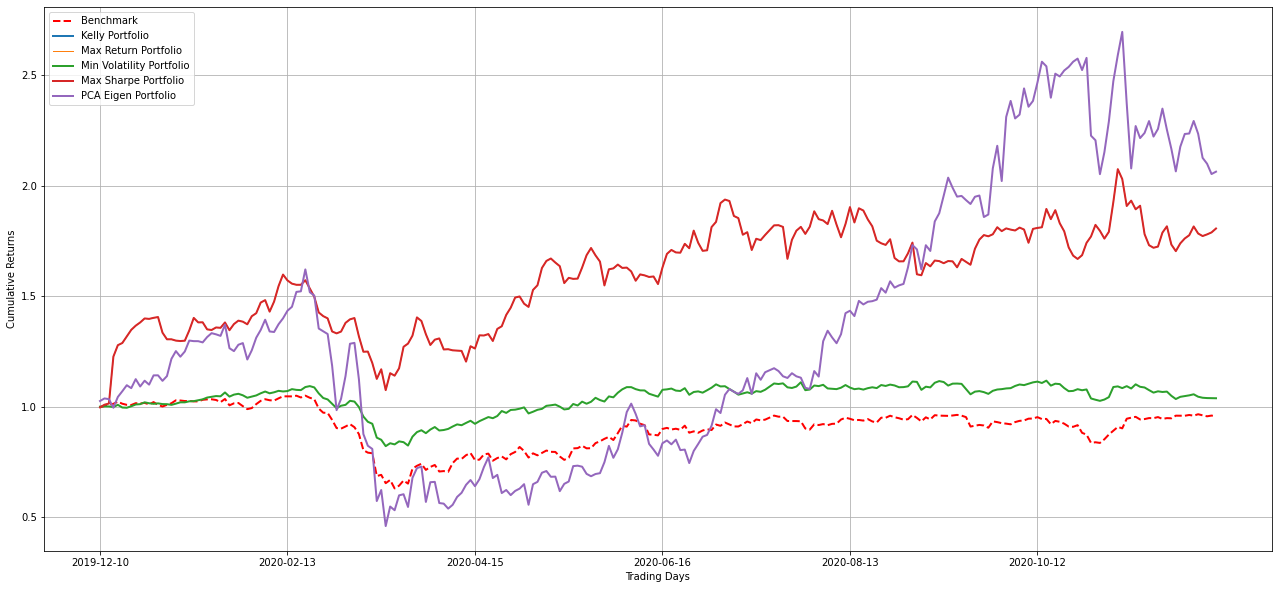

In [38]:
min_vola_port = P_summary(stock_returns, min_vola_opt_weights, benchmark)
PCA_eigen_returns = plotSharpe(eigen=plotEigen(weights=weights_PCA[23]), benchmark=benchmark_summary, plotting=False, return_returns=True)
port_kelly_returns = port_kelly_summary[4]

fig = plt.figure(figsize=(22, 10))

plt.plot(time[1:], np.cumprod(benchmark_summary[3]+1), 'r--', label='Benchmark', linewidth=2)
plt.plot(np.cumprod(port_kelly_returns+1), label='Kelly Portfolio', linewidth=2)
plt.plot(np.cumprod(max_exp_port[5]+1), label='Max Return Portfolio', linewidth=1)
plt.plot(np.cumprod(min_vola_port[5]+1), label='Min Volatility Portfolio', linewidth=2)
plt.plot(np.cumprod(max_exp_port[5]+1), label='Max Sharpe Portfolio', linewidth=2)
plt.plot(np.cumprod(PCA_eigen_returns+1), label='PCA Eigen Portfolio', linewidth=2)
plt.xticks(np.arange(0,len(time),len(time)/6))
plt.ylabel('Cumulative Returns')
plt.xlabel('Trading Days')
plt.legend()
plt.grid()
plt.show()

#Note that the returns from the Kelly Portfolio and the Max Return Portfolio are identical.